# Bagging 

## Building an ensemble of classifiers from bootstrap samples

Bagging is an ensemble learning technique in which we draw bootstrap samples (random samples with replacement) from the initial training dataset. Bagging is also known as *boostrap aggregating*. The following figure illustrates the concept of bagging.

In [1]:
# Imports
import pandas as pd

from IPython.display import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

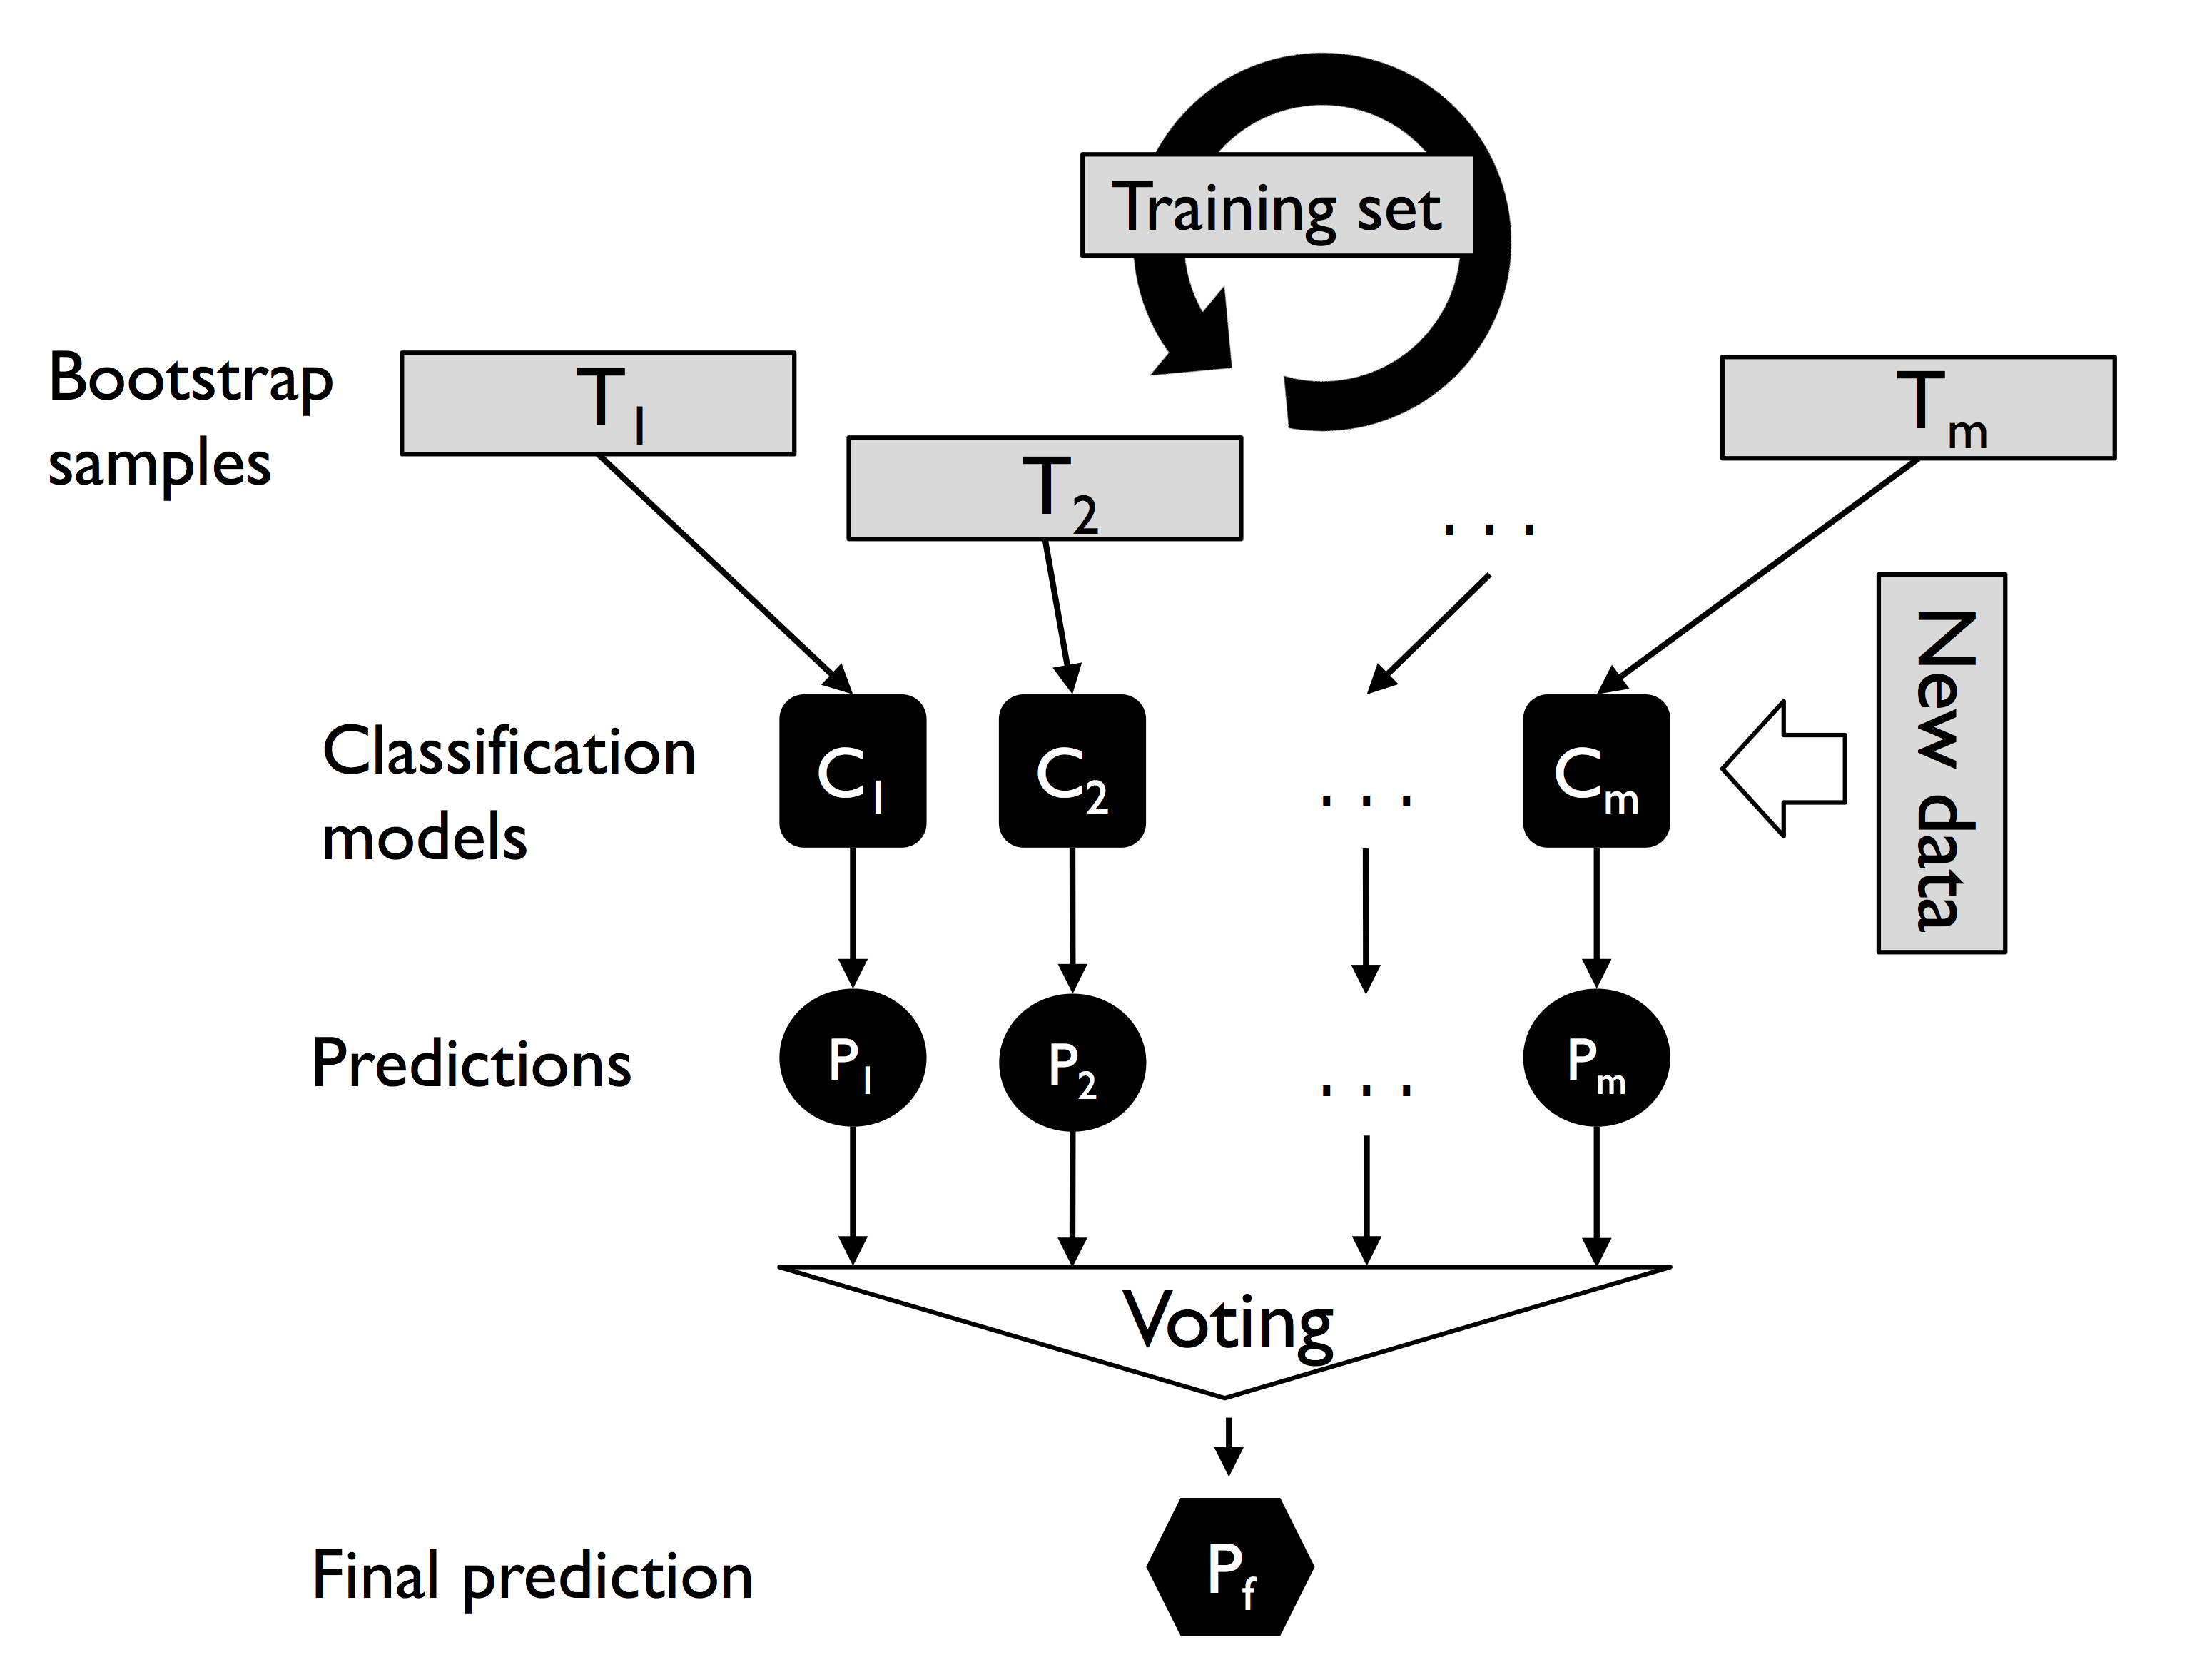

In [2]:
Image(filename='./images/bagging_1.png', width=500) 

## Bagging in a nutshell

To provide a concrete example of how the bootstrap aggregating of bagging classifier works, let's consider the example shown in the following figure. Here we have seven different training instances (denoted as indices 1-7) that are sampled randomly with replacement in each round of bagging. Each bootstrap sample is then used to fit a classifier, $C_{j}$, which is most tipically an unpruned decision tree: 

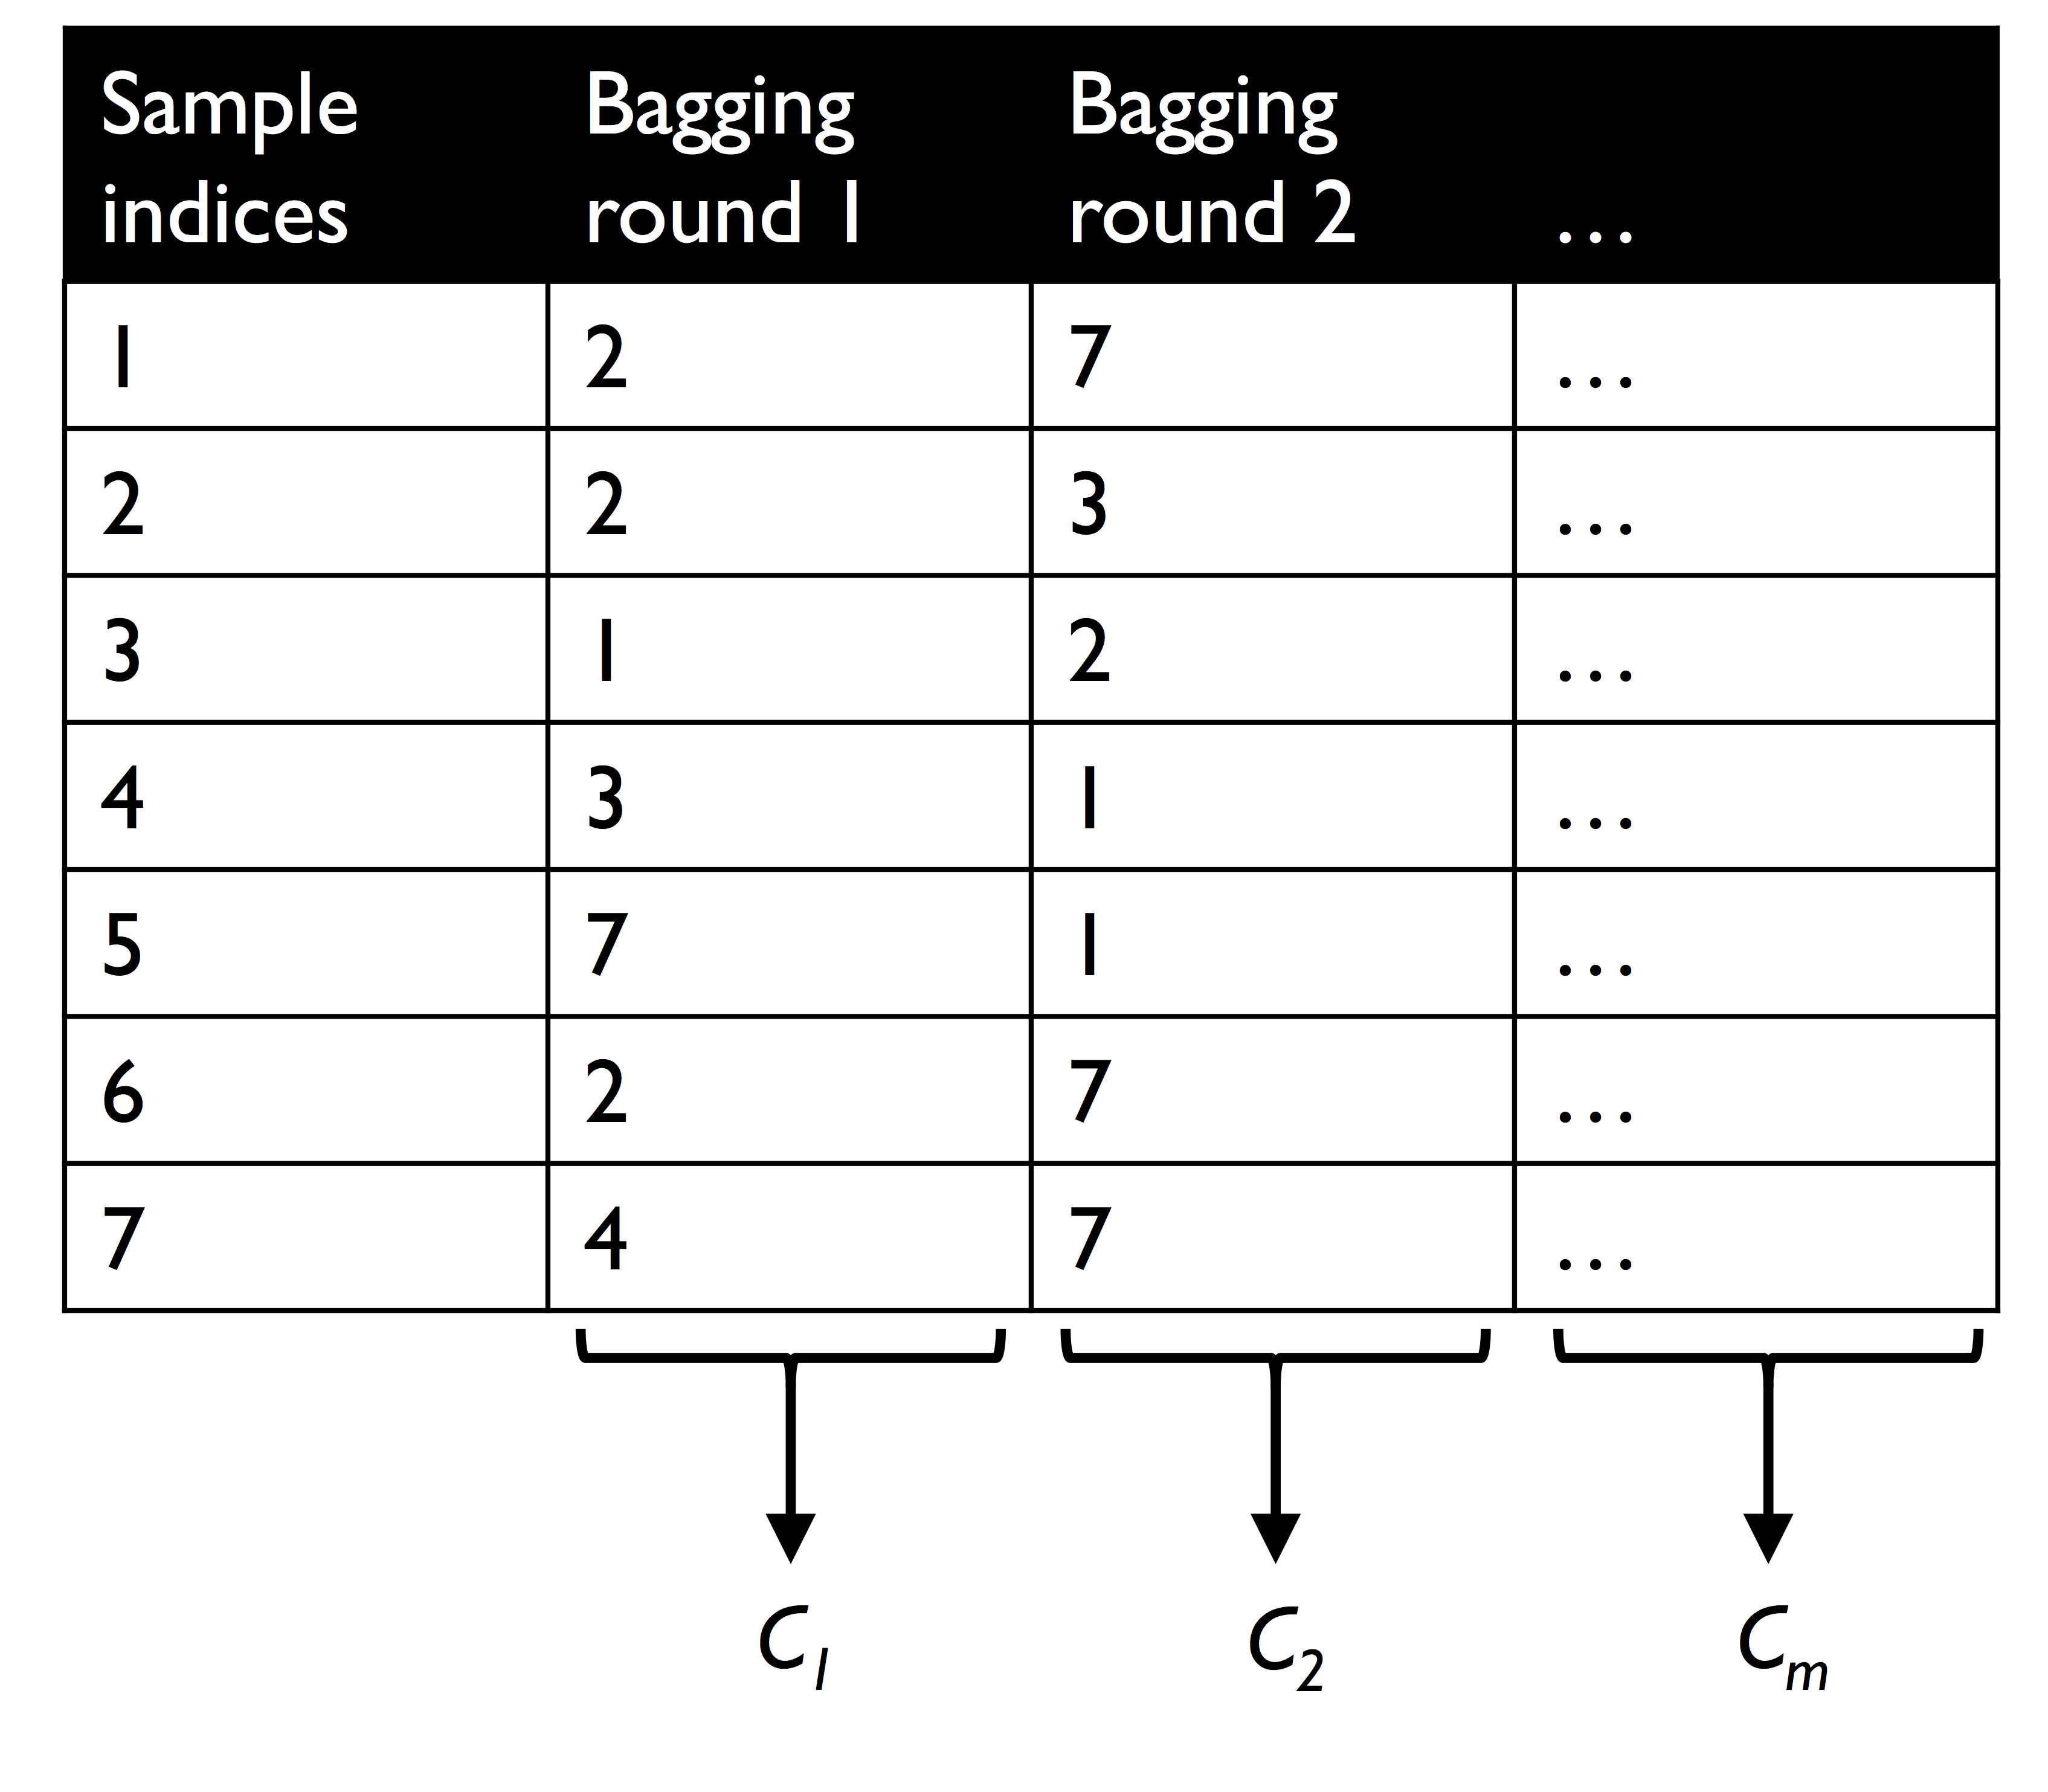

In [3]:
Image(filename='./images/bagging_2.png', width=400) 

As you can see from the previous illustration, each classifier receives a random subset of examples from the training dataset. We denote these random samples obtained via Bagging as *Bagging round 1*, *Bagging round 2*, and so on. Each subset contains a certain portion of duplicates and some of the original examples don't appear in a resampled dataset at all due to sampling with replacement. Once the individual classifiers are fit to the bootstrap samples, the predictions are combined using majority voting. 

## Applying bagging to classify examples in the Wine dataset

To see bagging in action, let's create a more complex classification problem using the Wine dataset. Here, we will only consider the Wine classes 2 and 3, and we will select two features: *Alcohol* and *OD280/OD315 of diluted wines*:

In [4]:
df_wine = pd.read_csv('wine.data', header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = df_wine['Class label'].values

Next, we will enconde the class labels into binary format and split the dataset into 80 percent training and 20 percent test datasets, respectively:

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

A *BaggingClassifier* algorithm is already implemented in scikit-learn, which we imported from the *ensemble* submodule. Here, we will use an unpruned decision tree as the base classifier, and create an ensemble of 500 decision trees fit on different bootstrap samples of the training dataset.

In [6]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

Next, we will calculate the accuracy score of prediction on the training and test datasets to compare the performance of the bagging classifier to the performance of a single unpruned decision tree:

In [7]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print('Decision tree train accuracy {:.3f}'.format(tree_train))
print('Decision tree test accuracy {:.3f}'.format(tree_test))

Decision tree train accuracy 1.000
Decision tree test accuracy 0.833


Based on the accuracy values that we printed here, the unpruned decision tree predicts all the class labels of the training examples correctly; however the substantially lower test accuracy indicates high variance (overfitting) of the model:

In [8]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 

print('Bagging train accuracy {:.3f}'.format(bag_train))
print('Bagging test accuracy {:.3f}'.format(bag_test))

Bagging train accuracy 1.000
Bagging test accuracy 0.917


Although the training accuracies of the decision tree and bagging classifier are similar on the training dataset (both 100 percent), we can see that the bagging classifier has a slightly better generalization performance, as estimated on the test dataset. Next, let's compare the decision regions between the decision tree and the bagging classifier:

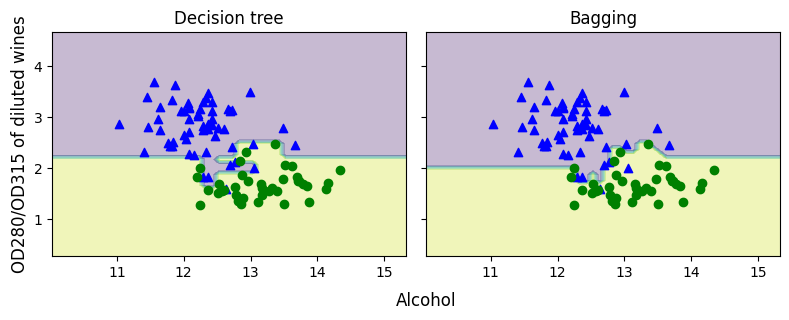

In [9]:
import numpy as np
import matplotlib.pyplot as plt

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

plt.show()

As we can see in the resulting plot, the piece-wise linear decision boundary of the three-node deep decision tree looks smoother in the bagging ensemble.

We only looked at a very simple bagging example in this notebook. In practice, more complex classification tasks and a dataset's high dimensionality can easily lead to overfitting in single decision trees, and this is where the bagging algorithm can really play to its strenghts. Finally, we must note that the bagging algorithm can be an effective approach to reducing the variance of a model. However, bagging is ineffective in reducing model bias, that is, models that are too simple to capture the trend in the data well. This is why we want to perform bagging on an ensemble of classifiers with low bias, for example, unpruned decision trees. 
